In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta

# Get list of days in expected format
sdate = date(2020, 1, 22)
today = date.today()
edate = date(today.year, today.month, today.day)
days = [(sdate + timedelta(days=i)).strftime('%m-%d-%Y') for i in range((edate - sdate).days + 1)]

# Merge all daily reports
merged = pd.DataFrame(columns = ['Province/State', 'Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered'])
for day in days:
    url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/' + day + '.csv'
    try:
        df = pd.read_csv(url)
        # Fix changes in column names if they exits
        df = df.rename({'Province_State':'Province/State', 'Country_Region':'Country/Region'}, axis=1)
        # Summerize US county data
        if 'Admin2' in df.columns.values:
            per_state = df[df['Country/Region'] == 'US'].groupby(['Province/State', 'Country/Region'], as_index=False).sum()
            df = df[df['Country/Region'] != 'US']
            df = pd.concat([df, per_state])
        df.drop([x for x in df.columns.values if x not in merged.columns.values], axis=1, inplace=True)
        df.insert(2, 'Date', [day for i in range(df.shape[0])])
        merged = pd.concat([merged, df])
    except IOError as e:
        print(str(e) + ' for: ' + day)
        continue

# Standerdize Country Names
pd.options.mode.chained_assignment = None
merged['Country/Region'].replace('United Kingdom', 'UK', inplace=True)
merged['Country/Region'].replace('Mainland China', 'China', inplace=True)
merged['Country/Region'].replace(['Korea, South', 'Republic of Korea'], 'South Korea', inplace=True)
merged['Country/Region'].replace('Iran (Islamic Republic of)', 'Iran',inplace=True)

# Standerdize US State Names
merged['Province/State'] = merged['Province/State'].str.strip()
merged['Province/State'].replace(regex={'^.*Virgin Islands.*$': 'Virgin Islands'}, inplace=True)
merged['Province/State'].replace(regex={'^(.+) \(From Diamond Princess\)$': r'\1'}, inplace=True)
merged['Province/State'].replace(regex={'^.*Diamond Princess.*$': 'Cruise Ship'}, inplace=True)
merged['Province/State'].replace(regex={'^.+, (.+)$': r'\1'}, inplace=True)
merged['Province/State'].replace(['District of Columbia', 'D.C.'], 'DC', inplace=True)
merged['Province/State'].replace('Chicago', 'IL', inplace=True)
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}
merged['Province/State'].replace(us_state_abbrev, inplace=True)

merged['Confirmed'].fillna(0, inplace=True)
merged['Deaths'].fillna(0, inplace=True)
merged['Recovered'].fillna(0, inplace=True)

#merged.to_csv('covid-summary-%s.csv' % today.strftime('%m-%d-%Y'))

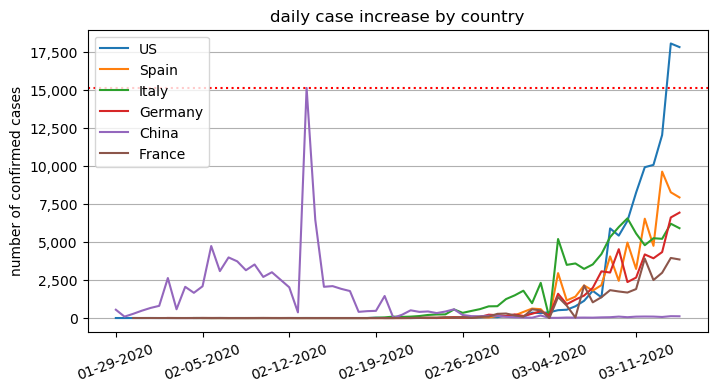

In [2]:
from pylab import *

# Aggregate at country level
country_level = merged.groupby(['Country/Region', 'Date'], as_index=False).sum()

# Countries to compare
inputs = ['US', 'Spain', 'Italy', 'Germany', 'China', 'France']
max_x = max(country_level[country_level['Country/Region'] == x].shape[0] for x in inputs)
fig, axes = plt.subplots(figsize=(8,4), dpi=100)
for i in range(len(inputs)):
    confirmed = country_level[country_level['Country/Region'] == inputs[i]]['Confirmed'].values.tolist()
    deltas = [confirmed[0]] + [confirmed[i] - confirmed[i-1] for i in range(1, len(confirmed))]
    # Pad each series to align them to the right
    deltas = [None] * (max_x - len(deltas)) + deltas
    axes.plot(deltas, label = inputs[i])

# Draw reference line
ref_totals = country_level[country_level['Country/Region'] == 'China']['Confirmed'].values.tolist()
ref = max([ref_totals[0]] + [ref_totals[i] - ref_totals[i-1] for i in range(1, len(ref_totals))])
plt.axhline(y=ref, color='r', linestyle=':')

axes.legend(loc=2)
axes.set_ylabel('number of confirmed cases')
axes.set_title('daily case increase by country');
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])
axes.set_xticklabels([days[i] for i in range(0, len(days), int(len(days)/len(axes.get_xticks().tolist())))])
plt.xticks(rotation=20)
plt.grid(axis='y')
#fig.savefig("daily-by-country.png", dpi=200)

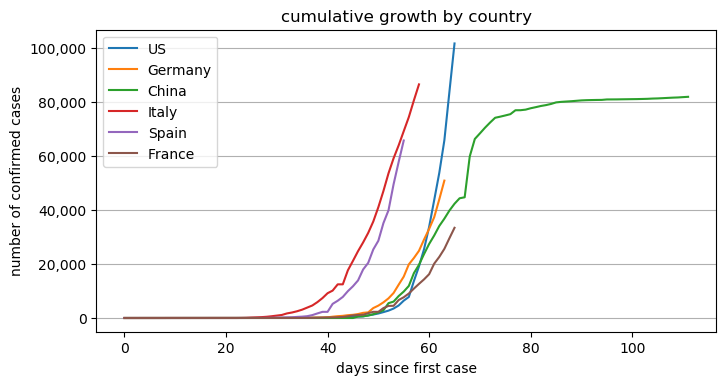

In [3]:
from pylab import *

def align(data):
    # Find the index with the lowest non-zero starting case number
    base = min(((idx, val) for (idx, val) in enumerate(data) if val[0] > 0), key = lambda x: x[1][0])[0]

    # Align everyone else to this base
    for i in [x for x in range(len(data)) if x != base]:
        padding = min(((x[0], abs(x[1] - data[i][0])) for x in enumerate(data[base])), key = lambda x: x[1])[0]
        data[i] = [0 for i in range(padding)] + data[i]
    return data

# Countries to compare
inputs = ['US', 'Germany', 'China', 'Italy', 'Spain', 'France']
data = align([[x for x in country_level[country_level['Country/Region'] == inputs[i]]['Confirmed'].values.tolist() if x > 0] for i in range(len(inputs))])

fig, axes = plt.subplots(figsize=(8,4), dpi=100)

for i in range(len(data)):
    axes.plot(data[i], label = inputs[i])

axes.legend(loc=2)
axes.set_xlabel('days since first case')
axes.set_ylabel('number of confirmed cases')
axes.set_title('cumulative growth by country');
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])
plt.grid(axis='y')
#fig.savefig("covid-by-country.png", dpi=200)

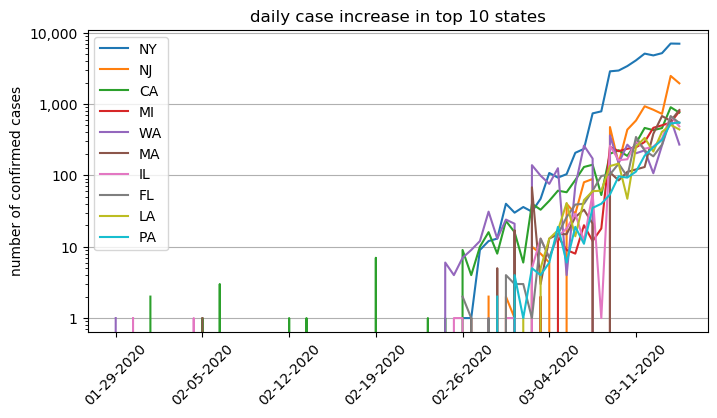

In [4]:
#from scipy.ndimage.filters import gaussian_filter1d

us_by_state = merged[merged['Country/Region'] == 'US'].groupby(['Province/State', 'Date'], as_index=False).sum()

# Find top 10 states
max_for_state = [(us_by_state[us_by_state['Province/State'] == x]['Confirmed'].max(), x) for x in us_by_state['Province/State'].unique()]
inputs = [x[1] for x in sorted(max_for_state, key=lambda x: x[0], reverse=True)[:10]]

max_x = max(us_by_state[us_by_state['Province/State'] == x].shape[0] for x in inputs)
fig, axes = plt.subplots(figsize=(8,4), dpi=100)
for i in range(len(inputs)):
    confirmed = us_by_state[us_by_state['Province/State'] == inputs[i]]['Confirmed'].values.tolist()
    deltas = [confirmed[0]] + [confirmed[i] - confirmed[i-1] for i in range(1, len(confirmed))]
    #deltas = gaussian_filter1d(deltas, sigma=2).tolist()
    # Pad each series to align them to the right
    deltas = [None] * (max_x - len(deltas)) + deltas
    axes.plot(deltas, label = inputs[i])

axes.legend(loc=2)
axes.set_yscale('log')
axes.set_ylabel('number of confirmed cases')
axes.set_title('daily case increase in top 10 states');
axes.set_yticklabels(['{:,}'.format(int(x)) for x in axes.get_yticks().tolist()])
axes.set_xticklabels([days[i] for i in range(0, len(days), int(len(days)/len(axes.get_xticks().tolist())))])
plt.xticks(rotation=45)
plt.grid(axis='y')

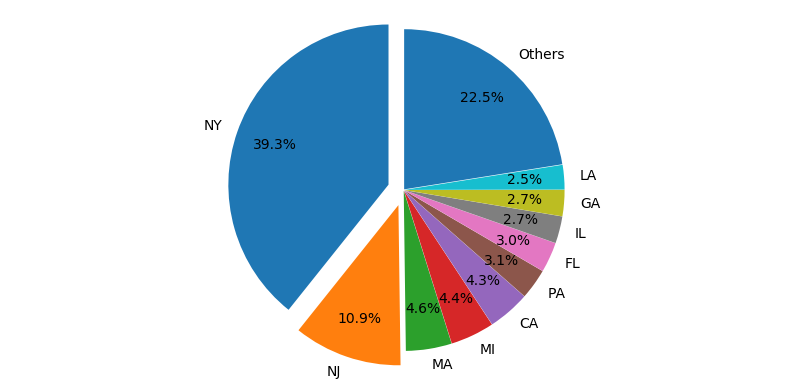

In [10]:
import matplotlib.pyplot as plt

data = []
for state in us_by_state[us_by_state['Date'] == days[-1]]['Province/State'].unique():
    today = us_by_state[(us_by_state['Date'] == days[-1]) & (us_by_state['Province/State'] == state)]['Confirmed'].iloc[0]
    yesterday = us_by_state[(us_by_state['Date'] == days[-2]) & (us_by_state['Province/State'] == state)]['Confirmed'].iloc[0]
    data.append((state, today-yesterday))

data = sorted(data, key=lambda x: x[1], reverse=True)
slices = 10
data = data[:slices] + [('Others', sum([x[1] for x in data[slices:]]))]
explode = [0.1, 0.1] + [0.005] * (slices - 1)

fig1, ax1 = plt.subplots(figsize=(8,4), dpi=100)
ax1.pie([x[1] for x in data], explode=explode, labels=[x[0] for x in data], autopct='%1.1f%%', shadow=False, startangle=90, pctdistance=0.75)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.tight_layout()
plt.show()
#fig1.savefig("today-by-state.png", dpi=200)